# Writing data concurrently

This notebook demonstrates how to submit tasks and write to a file concurrently

In [1]:
%load_ext watermark

In [24]:
import geowombat as gw
from geowombat.data import oli_2016_1213

import pyproj
import matplotlib.pyplot as plt

In [25]:
%watermark -a "GeoWombat examples" -d -v -m -p dask,geowombat,matplotlib,numpy,pyproj,rasterio,xarray -g

GeoWombat examples 2020-04-02 

CPython 3.7.5
IPython 7.13.0

dask 2.13.0
geowombat 1.2.9
matplotlib 3.2.1
numpy 1.18.2
pyproj 2.6.0
rasterio 1.1.3
xarray 0.15.1

compiler   : GCC 8.3.0
system     : Linux
release    : 4.15.0-91-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 3e0c9c881b50b9a6dd88c0e35a957051503576e2


---

# Workflow tasks

GeoWombat was originally developed to use third-party features to process large datasets concurrently on a distributed high-performance computer system. Therefore, workflows will look nearly identical to Xarray or Dask workflows until the task submission stage. Below, we demonstrate how to use GeoWombat for processing tasks.

# 1. Get to know the data

It is a good idea to examine the data attributes.

In [4]:
with gw.open(oli_2016_1213, chunks=512) as src:
    
    print(src)

<xarray.DataArray (band: 7, y: 926, x: 1419)>
dask.array<open_rasterio-98114e4a25a785d2e7ed4a6e441b7b96<this-array>, shape=(7, 926, 1419), dtype=uint16, chunksize=(7, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7
  * y        (y) float64 -4.974e+03 -5.004e+03 ... -3.27e+04 -3.273e+04
  * x        (x) float64 -1.983e+05 -1.983e+05 ... -1.558e+05 -1.558e+05
Attributes:
    transform:                     (30.003073249365293, 0.0, -198331.25947391...
    crs:                           +proj=aea +lat_1=-5 +lat_2=-42 +lat_0=-32 ...
    res:                           (30.003073249365293, 30.008057976603915)
    is_tiled:                      1
    nodatavals:                    (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    scales:                        (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
    offsets:                       (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:                 Area
    NC_GLOBAL#cell_size:           30
    NC_GLOBAL#date:  

# 2. Setup a task and test it

In this example, we will scale the data and compute the normalized difference vegetation index.

When testing the workflow on a large dataset, use the configuration manager to work on a subset area.

In [28]:
from geowombat.core import lonlat_to_xy

# Initial bounding coordinates (left, bottom, right, top) are in lat/lon
left, bottom, right, top = -62.08875908, -32.15712634, -61.98986763, -32.10169313

crs = pyproj.crs.CRS('ESRI:102033')

# Convert from lat/lon to map coordinates
left, top = lonlat_to_xy(left, top, crs)
right, bottom = lonlat_to_xy(right, bottom, crs)

ref_bounds = (left, bottom, right, top)

Setup a task and plot the results within the bounding box reference area.

<xarray.DataArray (band: 1, y: 210, x: 300)>
dask.array<broadcast_to, shape=(1, 210, 300), dtype=float64, chunksize=(1, 210, 300), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -1.311e+04 -1.314e+04 ... -1.935e+04 -1.938e+04
  * x        (x) float64 -1.886e+05 -1.886e+05 ... -1.796e+05 -1.796e+05
  * band     (band) <U4 'ndvi'
Attributes:
    transform:    (30.003073249365293, 0.0, -188601.6467271494, 0.0, -30.0080...
    crs:          +proj=aea +lat_1=-5 +lat_2=-42 +lat_0=-32 +lon_0=-60 +x_0=0...
    res:          (30.003073249365293, 30.008057976603915)
    is_tiled:     0
    nodatavals:   None
    scales:       1.0
    offsets:      0.0
    filename:     /home/jcgr/Documents/scripts/Python/envs/ts3.7/lib/python3....
    resampling:   nearest
    pre-scaling:  1.0
    sensor:       l8l7
    vi:           ndvi
    drange:       (-1, 1)


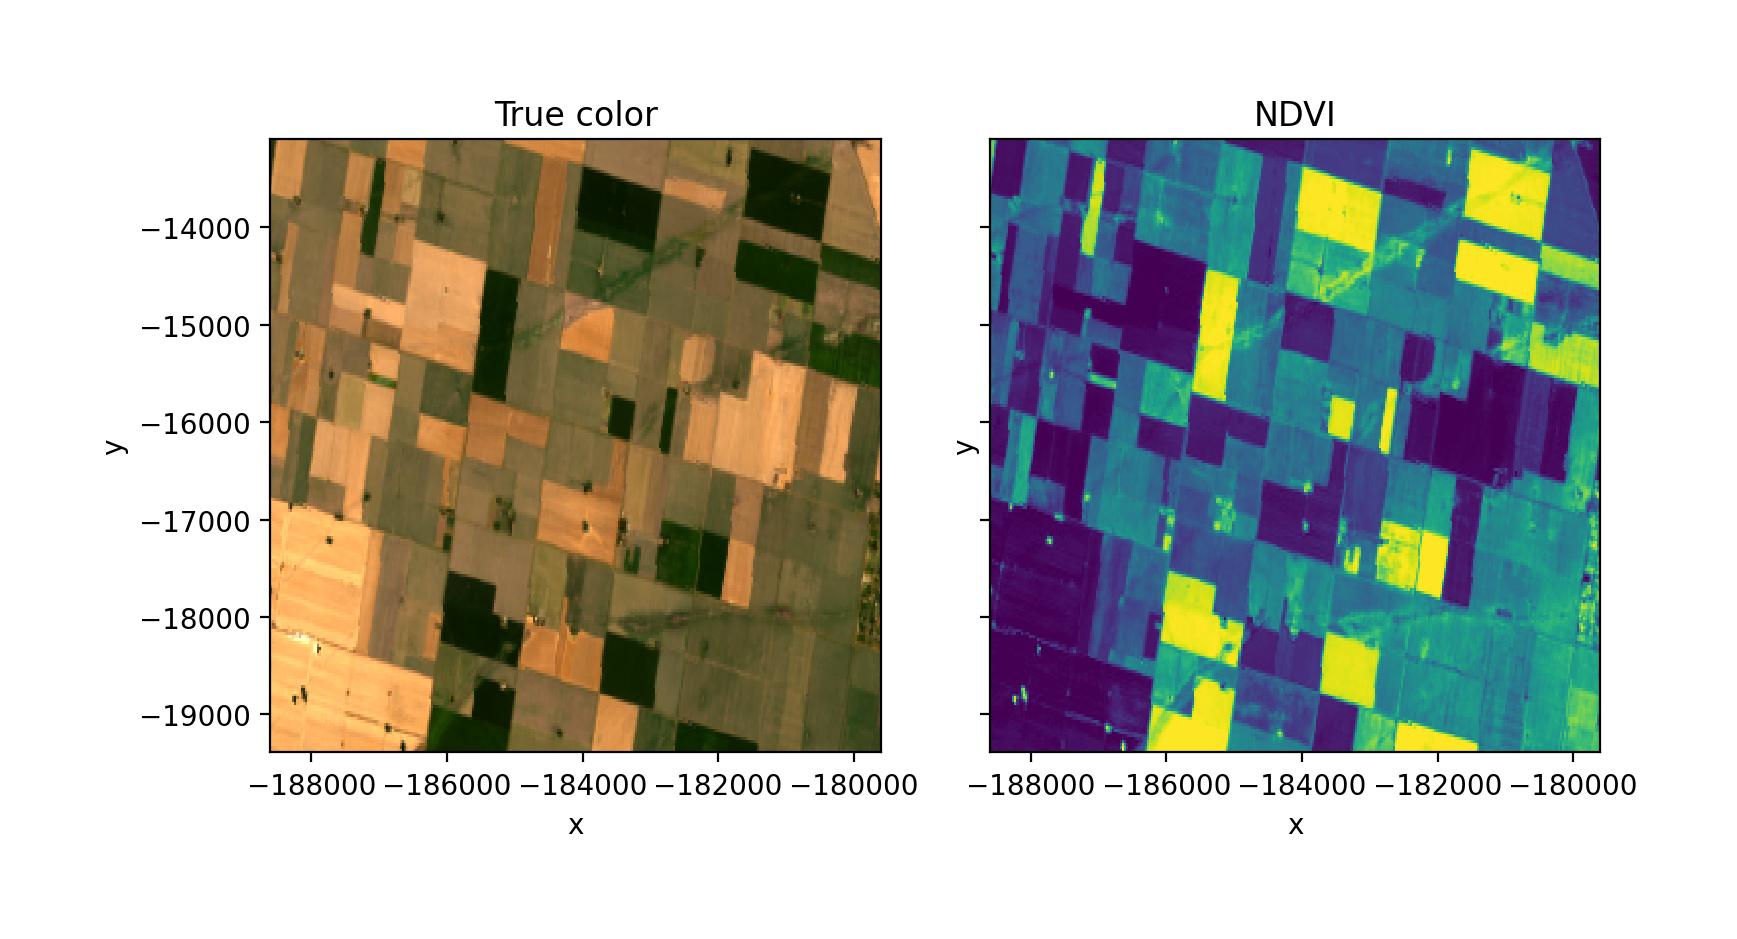

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=200, sharey=True)

with gw.config.update(ref_bounds=ref_bounds):

    with gw.open(oli_2016_1213, 
                 band_names=['coastal', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2'],
                 chunks=512) as src:
        
        attrs = src.attrs.copy()

        # Remove the 'coastal' band
        src_bands = src.sel(band=['blue', 'green', 'red', 'nir', 'swir1', 'swir2'])

        # Scale the data from 0-10000 to 0-1
        src_scaled = (src_bands*0.0001).clip(0, 1).astype('float64')
        
        src_scaled.attrs = attrs

        # Calculate the NDVI
        res = src_scaled.gw.ndvi(sensor='l8l7')

        print(res)

        src_bands.sel(band=['red', 'green', 'blue']).plot.imshow(robust=True, ax=ax1)
        res.sel(band='ndvi').plot.imshow(robust=True, add_colorbar=False, ax=ax2)

ax1.set_title('True color', size=12)    
ax2.set_title('NDVI', size=12)

plt.tight_layout()

# 3. Setup the full workflow task

Once you have a workflow that you are satisfied with, there are minimal changes needed to the test workflow. Here, we simply remove the context manager that set the reference bounds and the workflow will be applied across the entire image.

In [38]:
with gw.open(oli_2016_1213, 
             band_names=['coastal', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2'],
             chunks=512) as src:

    attrs = src.attrs.copy()
    
    # Remove the 'coastal' band
    src_bands = src.sel(band=['blue', 'green', 'red', 'nir', 'swir1', 'swir2'])
    
    # Scale the data from 0-10000 to 0-1
    src_scaled = (src_bands*0.0001).clip(0, 1).astype('float64')
    
    src_scaled.attrs = attrs
    
    # Calculate the NDVI
    res = src_scaled.gw.ndvi(sensor='l8l7')

    print(res)
    print('')
    print(help(res.gw.to_raster))

<xarray.DataArray (band: 1, y: 926, x: 1419)>
dask.array<broadcast_to, shape=(1, 926, 1419), dtype=float64, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -4.974e+03 -5.004e+03 ... -3.27e+04 -3.273e+04
  * x        (x) float64 -1.983e+05 -1.983e+05 ... -1.558e+05 -1.558e+05
  * band     (band) <U4 'ndvi'
Attributes:
    transform:                     (30.003073249365293, 0.0, -198331.25947391...
    crs:                           +proj=aea +lat_1=-5 +lat_2=-42 +lat_0=-32 ...
    res:                           (30.003073249365293, 30.008057976603915)
    is_tiled:                      1
    nodatavals:                    None
    scales:                        1.0
    offsets:                       0.0
    AREA_OR_POINT:                 Area
    NC_GLOBAL#cell_size:           30
    NC_GLOBAL#date:                1213
    NC_GLOBAL#jd:                  348
    NC_GLOBAL#jdr:                 2016348
    NC_GLOBAL#proj4:               +proj=aea +la

#### Note that no computation happened. To execute the workflow, use the `to_raster()` function. The `to_raster()` function can be called from the `DataArray.gw` object or from `geowombat`. The former will acquire the output data information directly from the DataArray, while the latter needs keywords set by the user.

In [39]:
with gw.open(oli_2016_1213, 
             band_names=['coastal', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2'],
             chunks=512) as src:

    attrs = src.attrs.copy()
    
    # Remove the 'coastal' band
    src_bands = src.sel(band=['blue', 'green', 'red', 'nir', 'swir1', 'swir2'])
    
    # Scale the data from 0-10000 to 0-1
    src_scaled = (src_bands*0.0001).clip(0, 1).astype('float64')
    
    src_scaled.attrs = attrs
    
    # Calculate the NDVI
    res = src_scaled.gw.ndvi(sensor='l8l7')

    res.gw.to_raster('ndvi_results.tif',
                     n_workers=4,
                     n_threads=1,
                     n_chunks=200)

100%|██████████| 6/6 [00:00<00:00, 364.50it/s]


Load the results from file

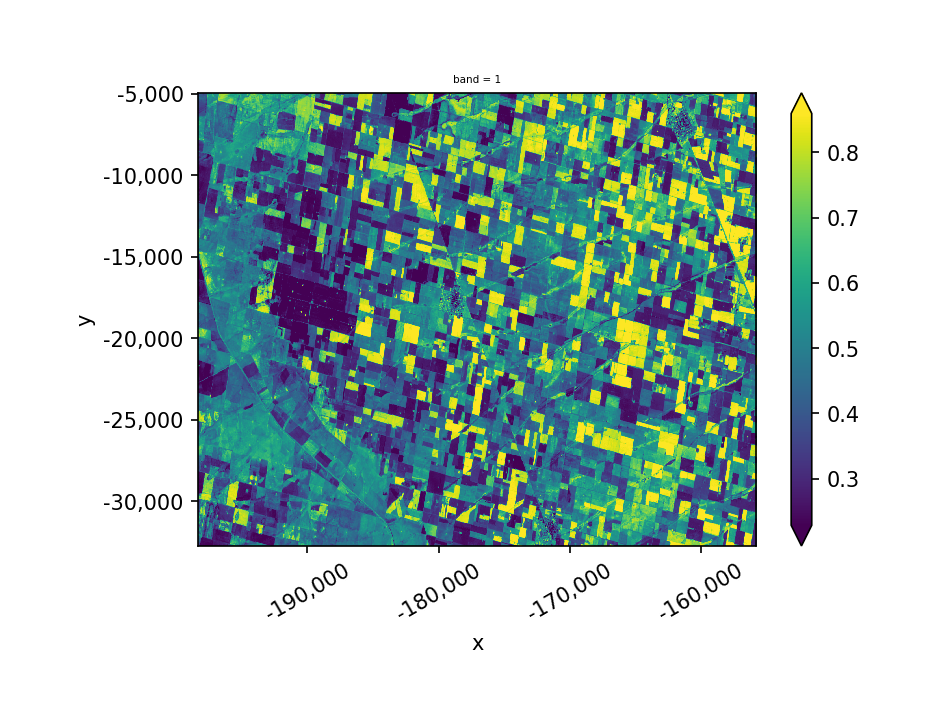

In [40]:
with gw.open('ndvi_results.tif') as src:
    src.sel(band=1).gw.imshow(robust=True)